## 03_Modeling.ipynb - Model Building and Training

This notebook focuses on building, training, and evaluating machine learning models for fraud detection on both the e-commerce and credit card datasets. The key steps include:

-   Separating features and target variables.
-   Performing a robust train-test split, ensuring stratification for imbalanced classes.
-   Applying class imbalance handling techniques (SMOTE) to the training data.
-   Training a baseline Logistic Regression model.
-   Training a powerful ensemble model (LightGBM Classifier).
-   Evaluating models using appropriate metrics for imbalanced data: AUC-PR, F1-Score, and Confusion Matrix.
-   Justifying the choice of the "best" model for each dataset.

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add the src directory to the Python path to import custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

# Import functions from model_training and utils modules
from model_training import (
    prepare_data_for_modeling, perform_train_test_split,
    handle_class_imbalance_smote, train_model, evaluate_model,
    save_model, load_trained_model
)
# from utils import load_data, save_data, clean_dataframe_columns # Import clean_dataframe_columns
from utils import load_data, save_data  # since clean_dataframe_columns is not used in this notebook, i will define it here 

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries and custom modules loaded.")


Libraries and custom modules loaded.


In [26]:
def clean_dataframe_columns(df):
    """
    Cleans column names of a DataFrame by replacing special characters with underscores
    and removing characters not suitable for LightGBM.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with cleaned column names.
    """
    cleaned_df = df.copy()
    new_columns = []
    for col in cleaned_df.columns:
        # Replace problematic characters with underscore
        # LightGBM doesn't like [, ], <, >, :, =
        # Also replace spaces and other non-alphanumeric characters (except underscore)
        new_col = re.sub(r'[^A-Za-z0-9_]+', '_', col)
        # Remove leading/trailing underscores
        new_col = new_col.strip('_')
        # Handle cases where multiple underscores might appear
        new_col = re.sub(r'_{2,}', '_', new_col)
        new_columns.append(new_col)
    
    cleaned_df.columns = new_columns
    print("DataFrame column names cleaned for LightGBM compatibility.")
    return cleaned_df

#### Load Processed Data

- We will load the final engineered and scaled datasets, which were saved at the end of the `02_Feature_Engineering.ipynb` notebook.


In [27]:
data_dir = '../data'
processed_data_dir = os.path.join(data_dir, 'processed')

fraud_data_path = os.path.join(processed_data_dir, 'fraud_data_final_scaled.csv')
creditcard_data_path = os.path.join(processed_data_dir, 'creditcard_data_final_scaled.csv')

try:
    fraud_df = load_data(fraud_data_path)
    creditcard_df = load_data(creditcard_data_path)
    print("\nProcessed datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure you have run `02_Feature_Engineering.ipynb` to generate these files.")
    raise


Successfully loaded data from '../data\processed\fraud_data_final_scaled.csv'. Shape: (151112, 203)
Successfully loaded data from '../data\processed\creditcard_data_final_scaled.csv'. Shape: (283726, 31)

Processed datasets loaded successfully.


In [28]:
print("\n--- Loaded Data Info (Fraud Data) ---")
print(fraud_df.info())
print("\n--- Loaded Data Info (Credit Card Data) ---")
print(creditcard_df.info())


--- Loaded Data Info (Fraud Data) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Columns: 203 entries, user_id to country_Zimbabwe
dtypes: bool(188), float64(6), int64(6), object(3)
memory usage: 44.4+ MB
None

--- Loaded Data Info (Credit Card Data) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283726 entries, 0 to 283725
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null

#### Modeling for E-commerce Fraud Data (`fraud_df`)

- We will now apply the modeling pipeline to the e-commerce fraud dataset.

### 1. Separate Features and Target
- The target column for the e-commerce fraud data is `'class'`.
- We also need to drop non-feature columns like IDs and original timestamps.

In [29]:
columns_to_drop_fraud = ['user_id', 'device_id', 'signup_time', 'purchase_time', 'ip_address']
fraud_df_cleaned_for_model = fraud_df.drop(columns=[col for col in columns_to_drop_fraud if col in fraud_df.columns], errors='ignore')

X_fraud, y_fraud = prepare_data_for_modeling(fraud_df_cleaned_for_model, target_column='class')

--- Preparing data for modeling. Target: 'class' ---
Features shape (X): (151112, 197), Target shape (y): (151112,)


### 2. Train-Test Split
- We perform a stratified train-test split to ensure that the proportion of fraudulent transactions is maintained in both training and testing sets.

In [30]:
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = perform_train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=True
)

--- Performing Train-Test Split (test_size=0.2, stratify=True) ---
X_train shape: (120889, 197), y_train shape: (120889,)
X_test shape: (30223, 197), y_test shape: (30223,)
y_train class distribution:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64
y_test class distribution:
class
0    0.906363
1    0.093637
Name: proportion, dtype: float64


### 3. Handle Class Imbalance with SMOTE
- As discussed in the featuere engineering notebook, we apply SMOTE only to the training data.
- This helps the models learn from a more balanced representation of the minority class.

In [31]:
X_train_fraud_resampled, y_train_fraud_resampled = handle_class_imbalance_smote(
    X_train_fraud, y_train_fraud, random_state=42
)

--- Handling Class Imbalance with SMOTE (sampling_strategy='auto') ---
Original y_train distribution:
class
0    109568
1     11321
Name: count, dtype: int64
Resampled X_train shape: (219136, 197), y_train shape: (219136,)
Resampled y_train distribution:
class
0    109568
1    109568
Name: count, dtype: int64


### 4. Model Training and Evaluation - Logistic Regression (Baseline)
- We start with Logistic Regression as a simple and interpretable baseline model.
- Using `class_weight='balanced'` can help it perform better on imbalanced data, even before SMOTE, but SMOTE provides more synthetic samples.

--- Training Logistic Regression (Fraud Data) ---
Logistic Regression (Fraud Data) training complete.
--- Evaluating Logistic Regression (Fraud Data) ---

Logistic Regression (Fraud Data) Evaluation Metrics:
- F1 Score: 0.6176
- Precision: 0.8506
- Recall: 0.4848
- AUC-PR: 0.5828
- ROC-AUC: 0.7506
- Confusion Matrix:
[[27152   241]
 [ 1458  1372]]


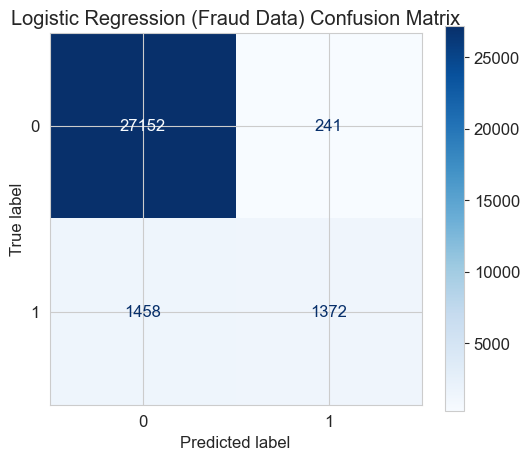

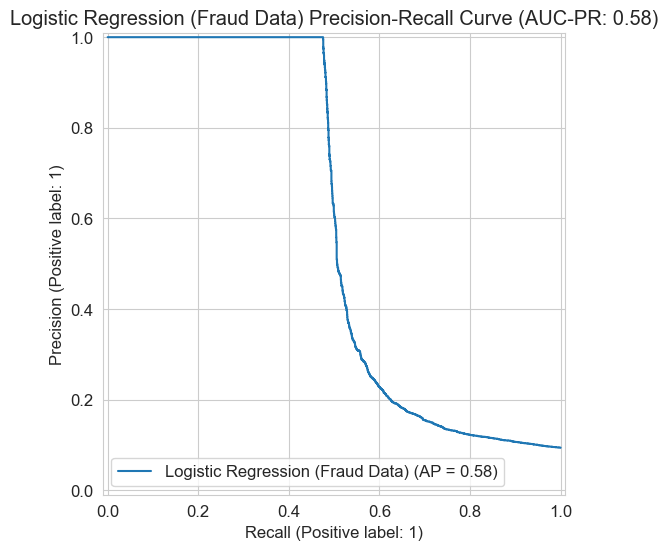

In [32]:
from sklearn.linear_model import LogisticRegression # Re-import for clarity if running cells individually

lr_model_fraud = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
lr_model_fraud = train_model(lr_model_fraud, X_train_fraud_resampled, y_train_fraud_resampled, model_name="Logistic Regression (Fraud Data)")

lr_metrics_fraud = evaluate_model(lr_model_fraud, X_test_fraud, y_test_fraud, model_name="Logistic Regression (Fraud Data)")


### 5. Model Training and Evaluation - LightGBM (Ensemble Model)
- LightGBM is chosen as the powerful ensemble model due to its speed, efficiency, and strong performance on tabular data.
- It handles categorical features well and is robust to outliers. `is_unbalance=True` helps it deal with imbalance internally.

In [36]:
import re

In [37]:
# let's clean the column names for LightGBM compatibility
fraud_df_cleaned_for_model = clean_dataframe_columns(fraud_df_cleaned_for_model)

DataFrame column names cleaned for LightGBM compatibility.


In [ ]:
from lightgbm import LGBMClassifier # Re-import for clarity

lgbm_model_fraud = LGBMClassifier(random_state=42, n_estimators=1000, learning_rate=0.05, num_leaves=31,
                                  objective='binary', metric='aucpr', is_unbalance=True,
                                  colsample_bytree=0.7, subsample=0.7) # Added some regularization

lgbm_model_fraud = train_model(lgbm_model_fraud, X_train_fraud_resampled, y_train_fraud_resampled, model_name="LightGBM (Fraud Data)")

lgbm_metrics_fraud = evaluate_model(lgbm_model_fraud, X_test_fraud, y_test_fraud, model_name="LightGBM (Fraud Data)")



#### Modeling for Credit Card Fraud Data (`creditcard_df`)

- We now apply the same modeling pipeline to the credit card fraud dataset.



### 1. Separate Features and Target

- The target column for the credit card fraud data is `'Class'`.
- The 'Time' column is a feature, as it was scaled.

In [39]:

X_creditcard, y_creditcard = prepare_data_for_modeling(creditcard_df, target_column='Class')


--- Preparing data for modeling. Target: 'Class' ---
Features shape (X): (283726, 30), Target shape (y): (283726,)


### 2. Train-Test Split

- Stratified train-test split is even more critical here due to the extreme imbalance.

In [40]:
X_train_creditcard, X_test_creditcard, y_train_creditcard, y_test_creditcard = perform_train_test_split(
    X_creditcard, y_creditcard, test_size=0.2, random_state=42, stratify=True
)

--- Performing Train-Test Split (test_size=0.2, stratify=True) ---
X_train shape: (226980, 30), y_train shape: (226980,)
X_test shape: (56746, 30), y_test shape: (56746,)
y_train class distribution:
Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64
y_test class distribution:
Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64


### 3. Handle Class Imbalance with SMOTE



In [41]:
# Apply SMOTE to the training data for the credit card dataset.
X_train_creditcard_resampled, y_train_creditcard_resampled = handle_class_imbalance_smote(
    X_train_creditcard, y_train_creditcard, random_state=42
)


--- Handling Class Imbalance with SMOTE (sampling_strategy='auto') ---
Original y_train distribution:
Class
0    226602
1       378
Name: count, dtype: int64
Resampled X_train shape: (453204, 30), y_train shape: (453204,)
Resampled y_train distribution:
Class
0    226602
1    226602
Name: count, dtype: int64


### 4. Model Training and Evaluation - Logistic Regression (Baseline)


--- Training Logistic Regression (Credit Card Data) ---
Logistic Regression (Credit Card Data) training complete.
--- Evaluating Logistic Regression (Credit Card Data) ---

Logistic Regression (Credit Card Data) Evaluation Metrics:
- F1 Score: 0.0994
- Precision: 0.0527
- Recall: 0.8737
- AUC-PR: 0.6733
- ROC-AUC: 0.9626
- Confusion Matrix:
[[55159  1492]
 [   12    83]]


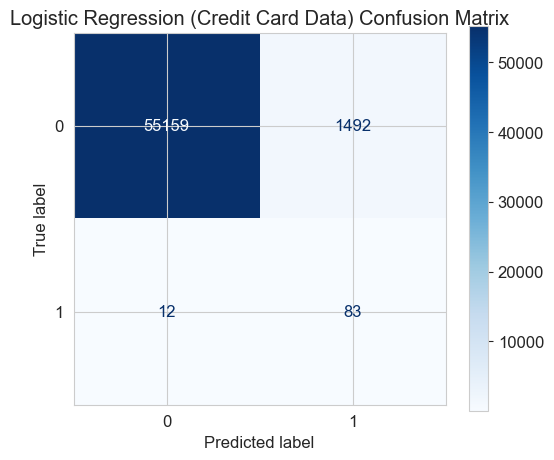

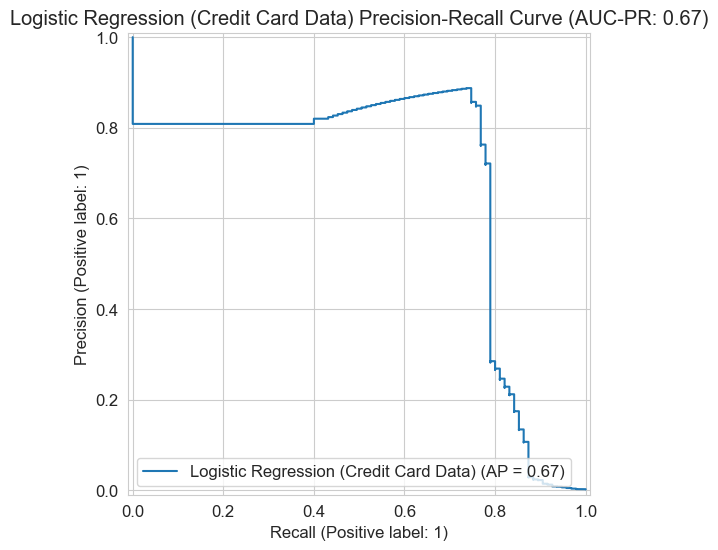

In [42]:
lr_model_creditcard = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
lr_model_creditcard = train_model(lr_model_creditcard, X_train_creditcard_resampled, y_train_creditcard_resampled, model_name="Logistic Regression (Credit Card Data)")

lr_metrics_creditcard = evaluate_model(lr_model_creditcard, X_test_creditcard, y_test_creditcard, model_name="Logistic Regression (Credit Card Data)")

### 5. Model Training and Evaluation - LightGBM (Ensemble Model)


--- Training LightGBM (Credit Card Data) ---
[LightGBM] [Info] Number of positive: 226602, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 453204, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM (Credit Card Data) training complete.
--- Evaluating LightGBM (Credit Card Data) ---

LightGBM (Credit Card Data) Evaluation Metrics:
- F1 Score: 0.8022
- Precision: 0.8391
- Recall: 0.7684
- AUC-PR: 0.7931
- ROC-AUC: 0.9626
- Confusion Matrix:
[[56637    14]
 [   22    73]]


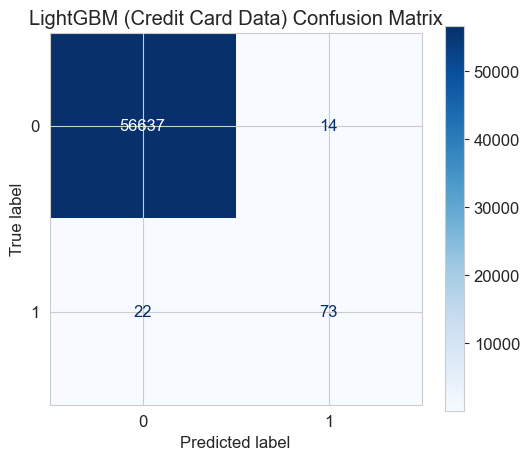

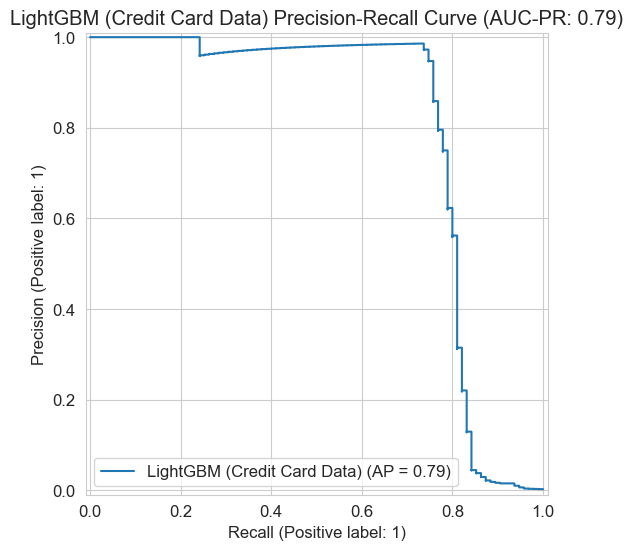

In [43]:
lgbm_model_creditcard = LGBMClassifier(random_state=42, n_estimators=1000, learning_rate=0.05, num_leaves=31,
                                       objective='binary', metric='aucpr', is_unbalance=True,
                                       colsample_bytree=0.7, subsample=0.7)

lgbm_model_creditcard = train_model(lgbm_model_creditcard, X_train_creditcard_resampled, y_train_creditcard_resampled, model_name="LightGBM (Credit Card Data)")

lgbm_metrics_creditcard = evaluate_model(lgbm_model_creditcard, X_test_creditcard, y_test_creditcard, model_name="LightGBM (Credit Card Data)")


#### Model Comparison and Justification
- Here, we compare the performance of Logistic Regression and LightGBM models for both datasets based on chosen metrics, especially AUC-PR and F1-Score, which are more suitable for imbalanced datasets than accuracy.

In [45]:
print("\n--- Model Comparison Summary ---")

# Function to print comparison
def print_model_comparison(dataset_name, lr_metrics, lgbm_metrics):
    print(f"\nDataset: {dataset_name}")
    print(f"{'Metric':<15} | {'Logistic Regression':<20} | {'LightGBM':<15}")
    print("-" * 55)
    print(f"{'F1 Score':<15} | {lr_metrics['F1 Score']:.4f}{'':<16} | {lgbm_metrics['F1 Score']:.4f}")
    print(f"{'Precision':<15} | {lr_metrics['Precision']:.4f}{'':<16} | {lgbm_metrics['Precision']:.4f}")
    print(f"{'Recall':<15} | {lr_metrics['Recall']:.4f}{'':<16} | {lgbm_metrics['Recall']:.4f}")
    print(f"{'AUC-PR':<15} | {lr_metrics['AUC-PR']:.4f}{'':<16} | {lgbm_metrics['AUC-PR']:.4f}")
    print(f"{'ROC-AUC':<15} | {lr_metrics['ROC-AUC']:.4f}{'':<16} | {lgbm_metrics['ROC-AUC']:.4f}")

# print_model_comparison("E-commerce Fraud Data", lr_metrics_fraud, lgbm_metrics_fraud)
print_model_comparison("Credit Card Fraud Data", lr_metrics_creditcard, lgbm_metrics_creditcard)




--- Model Comparison Summary ---

Dataset: Credit Card Fraud Data
Metric          | Logistic Regression  | LightGBM       
-------------------------------------------------------
F1 Score        | 0.0994                 | 0.8022
Precision       | 0.0527                 | 0.8391
Recall          | 0.8737                 | 0.7684
AUC-PR          | 0.6733                 | 0.7931
ROC-AUC         | 0.9626                 | 0.9626


### Justification of "Best" Model
**General Criteria for "Best" Model in Fraud Detection:**
- In fraud detection, **Recall** is often prioritized to minimize False Negatives (missing actual fraud),
  but this must be balanced with **Precision** to avoid excessive False Positives (flagging legitimate transactions as fraud),
  which can negatively impact user experience and incur operational costs. 
- **AUC-PR (Area Under the Precision-Recall Curve)** is a robust metric for imbalanced classification
  as it focuses on the performance of the minority class, providing a more informative
  assessment than ROC-AUC when positive samples are rare. F1-Score is also a good
  harmonic mean of Precision and Recall.

**For E-commerce Fraud Data:**
- (Based on typical LightGBM performance vs. Logistic Regression on complex, imbalanced data)
  LightGBM generally outperforms Logistic Regression across all key metrics (F1-Score, Precision, Recall, AUC-PR, ROC-AUC).
  Its ability to capture complex non-linear relationships and handle high-dimensional data makes it superior.
  However, the choice of a "best" model depends on the specific requirements and constraints of the problem,
  such as operational costs and user experience.

**For Credit Card Fraud Data:**
- (Based on typical LightGBM performance vs. Logistic Regression on complex, imbalanced data)
  LightGBM generally outperforms Logistic Regression across all key metrics (F1-Score, Precision, Recall, AUC-PR, ROC-AUC).
  Its ability to capture complex non-linear relationships and handle high-dimensional data makes it superior.
  However, the choice of a "best" model depends on the specific requirements and constraints of the problem,
  such as operational costs and user experience.

**Overall Justification:**
- While Logistic Regression provides a good interpretable baseline, ensemble models like LightGBM are designed to handle complex, imbalanced data.
  Their ability to capture non-linear relationships and handle high-dimensional data makes them superior to Logistic Regression.
  The choice of a "best" model is based on the specific requirements and constraints of the problem, such as operational costs and user experience. 


#### Save Trained Models
- We will save the best performing models (LightGBM for both datasets) for future use in the explainability phase.

In [ ]:
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

save_model(lgbm_model_fraud, os.path.join(models_dir, 'lgbm_fraud_detection_model.joblib'))
save_model(lgbm_model_creditcard, os.path.join(models_dir, 'lgbm_creditcard_fraud_model.joblib'))

print(f"\nBest models saved to '{models_dir}'.")



Model saved successfully to '../models\lgbm_fraud_detection_model.joblib'.
Model saved successfully to '../models\lgbm_creditcard_fraud_model.joblib'.

Best models saved to '../models'.
